In [1]:
import math
import tqdm
import random

# import feature_generators
# import timeseries

import pandas as pd
import numpy as np
import scipy as sp

from collections import defaultdict
from datetime import datetime
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import LinearSVC, SVC

# np.random.seed(42)
# random.seed(a=472443)

# From http://s.arboreus.com/2009/04/cyrillic-letters-in-matplotlibpylab.html
# from matplotlib import rc
# rc('font',**{'family':'serif'})
# rc('text', usetex=True)
# rc('text.latex',unicode=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')

import pcst_fast

In [2]:
class SeedStorage:
    def __init__(self, seed=None):
        self.seed = seed
    def __call__(self):
        if self.seed is None:
            seed = None
        else:
            seed = self.seed
            self.seed += 1
        return seed

In [3]:
MainSeedStorage = SeedStorage(42)

class MyFuncDesc(object):
    def __init__(self, func, func_name, arity, complexity):
        self.func = func
        self.func_name = func_name
        self.arity = arity
        self.complexity = complexity

class MatrixFunc(object):
    def __init__(self, func_list,
                 var_number=None, adj_matrix=None, sigma=0.0):
        self.np_norm_random_gen = np.random.RandomState(MainSeedStorage()).normal
        self.func_list = func_list
        self.sigma = sigma
        self.var_number = var_number
        self.func_number = len(func_list)
        
        if adj_matrix is None:
            self.adj_matrix = np.zeros((self.func_number, self.func_number + self.var_number),
                                       dtype=int)
        else:
            self.adj_matrix=adj_matrix
            
        self.func = None
        
    def MakeFunctionFromMatrix(self, level=0, used=set(), print_func=False):
        level_func = self.func_list[level]
        matrix_row = self.adj_matrix[level].copy()
        
        matrix_row[list(used)] = 0

        to_print = None
        rec_to_print = [''] * level_func.arity
        if print_func:
            to_print = level_func.func_name

        used.add(level)

        new_level_funcs = []
        new_level_func = None
        for i in range(level_func.arity):
            new_argmax = np.argmax(matrix_row)
            if (new_level_func is None or not matrix_row[new_argmax] == 0):
                new_level_func = new_argmax
            matrix_row[new_level_func] = 0
            # new_level_func += 1

            new_level_funcs.append(new_level_func)

            if new_level_func >= self.func_number:
                new_level_funcs[i] -= self.func_number
                rec_to_print[i] = 'x_{}'.format(new_level_funcs[i])
            else:
                new_level_funcs[i], rec_to_print[i] = \
                    self.MakeFunctionFromMatrix(new_level_funcs[i], used.copy(), print_func)

        if print_func:  
            to_print = to_print.format(*rec_to_print)

        def func(args, new_level_funcs=new_level_funcs):
            new_level_funcs_copy = new_level_funcs.copy()
            for i in range(level_func.arity):
                if not callable(new_level_funcs[i]):
                    # print(new_level_funcs[i])
                    new_level_funcs_copy[i] = args[:, new_level_funcs[i]]
                else:
                    new_level_funcs_copy[i] = new_level_funcs[i](args)
            return level_func.func(*new_level_funcs_copy)

        if level == 0:
            self.func = func
            return func, to_print
        else:
            return func, to_print

    def __call__(self, X):
        if self.func is None:
            self.MakeFunctionFromMatrix()

        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))
        # print(X)
        return self.func(X) + self.np_norm_random_gen(size=X.shape[0]) * self.sigma

def MakeRandomFunc(mat_func, complexity_limit=-1):
    '''
    Creates a random matrix for MatrixFunc 
    (given func_list from mat_func MatrixFunc object)
    
    Parameters
    -------------------------------------------------
    mat_func:
        MatrixFunc object with func_list in it

    complexity_limit:
        Specifies the depth of a function complexity, 
        with -1 == no limits. For example,
        sin(ln(x)) + cos(x) has a complexity of 2.
    '''
    queue = [(0, 0)]

    total_num = mat_func.func_number + mat_func.var_number
    var_set = set(range(total_num)) - set(range(mat_func.func_number))
    not_used = set(range(total_num)) - set([queue[0][0]])

    while not len(queue) == 0:
        func = mat_func.func_list[queue[0][0]]
        cmplx = queue[0][1]
        #print(queue)
        #print(cmplx, complexity_limit, func.func_name)
        chosen = []
        if (cmplx < complexity_limit or complexity_limit == -1):
            if len(not_used) >= func.arity:
                chosen = random.sample(not_used, func.arity)
            else:
                chosen = random.sample(not_used, len(not_used))

        # print(var_set)
        while len(chosen) < func.arity:
            chosen.append(random.sample(var_set, 1)[0])

        for i in range(func.arity):
            chosen_elem = chosen[i]
            # chosen_elem = random.sample(not_used, 1)[0]
            if chosen_elem < mat_func.func_number:
                not_used = not_used - set([chosen_elem])
                queue.append((chosen_elem, cmplx + mat_func.func_list[chosen_elem].complexity))
            mat_func.adj_matrix[queue[0][0], chosen_elem] = 1
        queue[:] = queue[1:]
    return mat_func

def MatrixFuncFromProbMatrix(func_list, prob_matrix, method='greedy_dfs'):
    '''
    Creates a MatrixFunc object given func_list and
    probabilities matrix prob_matrix using specified method
    
    
    Parameters
    -------------------------------------------------
    func_list:
        List of base functions to build superpositions

    prob_matrix:
        Probabilities matrix to restore a matrix defining a
        superposition
    
    method:
        A restoration method
    '''
    if method == 'greedy_dfs':
        new_matrix = np.zeros(prob_matrix.shape, dtype=int)
        def GreedyRestoreDFS(func_list, prob_matrix, new_matrix, level=0, used=set()):
            level_func = func_list[level]
            matrix_row = prob_matrix[level].copy()

            matrix_row[list(used)] = 0
            used.add(level)

            new_level_func = None
            for i in range(level_func.arity):
                new_argmax = np.argmax(matrix_row)
                if (new_level_func is None or not matrix_row[new_argmax] == 0):
                    new_level_func = new_argmax
                matrix_row[new_level_func] = 0
                # new_level_func += 1
                new_matrix[level, new_level_func] = 1

                if new_level_func < len(func_list):
                    GreedyRestoreDFS(func_list, prob_matrix, new_matrix,
                                     new_level_func, used.copy())

            return
        
        GreedyRestoreDFS(func_list, prob_matrix, new_matrix, level=0, used=set())
        
        return MatrixFunc(func_list, var_number=prob_matrix.shape[1] - prob_matrix.shape[0],
                          adj_matrix=new_matrix)

Попробуем для начала на примере из работы Варфоломеевой. Создадим функцию (зададим лист функций но пока не опишем матрицу):

In [4]:
f_sum = MyFuncDesc(lambda x, y, z: x + y + z, '{} + {} + {}', 3, 0)
f_times = MyFuncDesc(lambda x, y: x * y, '{} * {}', 2, 1)

eps = 0.001
f_ln = MyFuncDesc(lambda x: np.log(np.abs(x) + eps), 'ln(abs({}) + 0.001)', 1, 2)
f_sin = MyFuncDesc(np.sin, 'sin({})', 1, 1)

f_list = [f_sum, f_times, f_ln, f_sin]

MF = MatrixFunc(f_list, var_number=1)

Теперь заполним матрицу и построим функцию:

In [5]:
MF.adj_matrix[0, 1] = 1
MF.adj_matrix[0, 2] = 1
MF.adj_matrix[1, 3] = 1
MF.adj_matrix[1, 4] = 1
MF.adj_matrix[2, 4] = 1
MF.adj_matrix[3, 4] = 1

# print(MF.adj_matrix)

f, g = MF.MakeFunctionFromMatrix(print_func=True)
print(g)

sin(x_0) * x_0 + ln(abs(x_0) + 0.001) + ln(abs(x_0) + 0.001)


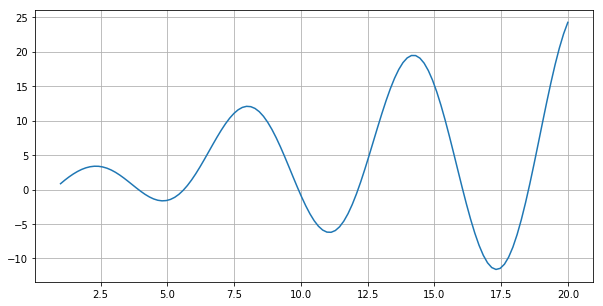

In [6]:
X = np.linspace(1.0, 20.0, 121)
Y = MF(X.reshape(121, 1))

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(X, Y)

http://yotx.ru/#!1/3_h/tb%40zsH%400YM4X9t/2h/c%40tsf%40dg34gh/K/t/wPhG3u74D0oAb6xt7t/sE%40iYTd2ThmPp1uMx63Li939rX0B

Теперь проверим случайную генерацию функций (при фиксированном списке):

x_0 * x_0 + ln(abs(x_0) + 0.001) + x_0


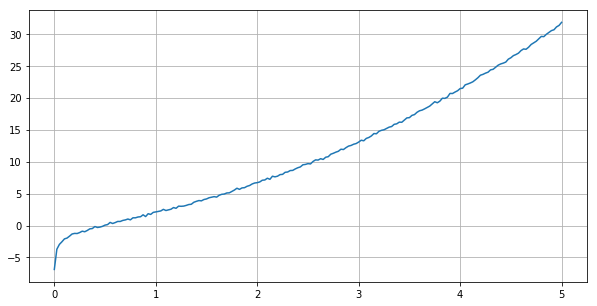

In [7]:
MF = MatrixFunc(f_list, var_number=1, sigma=0.1)

MF = MakeRandomFunc(MF, 1)
# MF.adj_matrix

f, g = MF.MakeFunctionFromMatrix(print_func=True)
print(g)

X = np.linspace(0.0, 5.0, 201)
Y = MF(X.reshape(201, 1))

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(X, Y)

Теперь план такой:
    
 - 1) Задаем набор функций ($functions\_list$), по нему генерируем 2-3 десятка порождающих функций.
 - 2) Далее для каждого уровня зашумленности (sigma) строится несколько зашумленных наборов данных (пары ((X, y), M) где M - матрица породившая данную функцию (при фиксированном листе)
 - 3) sklearn.что-нибудь, многомерная регрессия. Предугадываем матрицы. Здесь еще нужны метрики, работающие с sklearn. 
 - 4) Восстанавливаем матрицы, сравниваем с порождающей. 
 
 ##### 1)

In [8]:
f_sum = MyFuncDesc(lambda x1, x2, x3: x1 + x2 + x3, '{} + {} + {}', 3, 0)
f_times = MyFuncDesc(lambda x, y: x * y, '{} * {}', 2, 1)

def get_cossin_f(alpha=1.0, cos=True):
    if cos:
        return MyFuncDesc(lambda x: np.cos(alpha * x), 'cos({})'.format(str(alpha) + '({})'), 1, 1)
    else:
        return MyFuncDesc(lambda x: np.sin(alpha * x), 'sin({})'.format(str(alpha) + '({})'), 1, 1)

alphas = [1.0, 3.0, 5.0, 7.0, 9.0]

f_sin = [get_cossin_f(alpha=x, cos=False) for x in alphas]
f_cos = [get_cossin_f(alpha=x, cos=True) for x in alphas]

f_list = [f_sum, f_times, *f_sin, *f_cos]

In [9]:
random.seed(a=472443)

MF_list = []

for i in range(0, 21):
    MF = MatrixFunc(f_list, var_number=1, sigma=0)
    MF = MakeRandomFunc(MF, 1)

    f, g = MF.MakeFunctionFromMatrix(print_func=True)
    
    flag = False
    for MF_old in MF_list:
        if (MF_old.adj_matrix == MF.adj_matrix).all():
            flag = True
            break
        
    print(g)
    if not flag:
        MF_list.append(MF)

len(MF_list)
# X = np.linspace(0.0, 5.0, 201)
# Y = MF(X.reshape(201, 1))

# plt.figure(figsize=(10, 5))
# plt.grid(True)
# plt.plot(X, Y)

x_0 * x_0 + sin(1.0(x_0)) + cos(9.0(x_0))
sin(5.0(x_0)) + cos(3.0(x_0)) + cos(7.0(x_0))
cos(3.0(x_0)) + cos(7.0(x_0)) + cos(9.0(x_0))
sin(3.0(x_0)) + sin(7.0(x_0)) + cos(5.0(x_0))
sin(3.0(x_0)) + sin(7.0(x_0)) + cos(9.0(x_0))
x_0 * x_0 + sin(1.0(x_0)) + sin(7.0(x_0))
sin(5.0(x_0)) + sin(7.0(x_0)) + cos(5.0(x_0))
sin(1.0(x_0)) + cos(7.0(x_0)) + cos(9.0(x_0))
x_0 * x_0 + sin(1.0(x_0)) + cos(9.0(x_0))
sin(5.0(x_0)) + cos(1.0(x_0)) + cos(9.0(x_0))
sin(5.0(x_0)) + sin(9.0(x_0)) + x_0
sin(7.0(x_0)) + cos(1.0(x_0)) + cos(7.0(x_0))
x_0 * x_0 + cos(3.0(x_0)) + x_0
sin(3.0(x_0)) + sin(9.0(x_0)) + cos(9.0(x_0))
cos(3.0(x_0)) + cos(5.0(x_0)) + cos(7.0(x_0))
x_0 * x_0 + cos(3.0(x_0)) + cos(7.0(x_0))
sin(3.0(x_0)) + sin(5.0(x_0)) + sin(7.0(x_0))
sin(7.0(x_0)) + cos(1.0(x_0)) + cos(9.0(x_0))
sin(3.0(x_0)) + sin(5.0(x_0)) + x_0
sin(1.0(x_0)) + sin(5.0(x_0)) + cos(7.0(x_0))
sin(3.0(x_0)) + sin(7.0(x_0)) + sin(9.0(x_0))


20

In [10]:
def mse(ground_truth, predictions):
    # print((np.linalg.norm(ground_truth - predictions, axis=1) ** 2).shape, type(predictions))
    diff = (np.linalg.norm(ground_truth - predictions, axis=1) ** 2).sum() / len(predictions)
    return diff


def do_exp_sigma_dependancy_dataset(MF_list, X=np.linspace(0.0, 5.0, 251),
                                    sigma=0.0, tries=10):
    X = X.reshape(len(X), 1)
    # sigmas = np.linspace(0.0, 3.0, 4)
    # X = np.linspace(0.0, 5.0, 251)
    data_X = np.zeros((len(MF_list) * tries, len(X)))
    data_Y = np.zeros((len(MF_list) * tries, len(np.ravel(MF_list[0].adj_matrix))))

    for i, MF in enumerate(MF_list):
        MF.sigma = sigma
        for j in range(0, tries):
            data_X[i * tries + j] = MF(X)
            data_Y[i * tries + j] = np.ravel(MF_list[i].adj_matrix)

    return data_X, data_Y


def do_exp(MF_list, f_list, sigmas):
    
    mses_before_restoration = []
    mses_after_restoration = []
    recovered = []
    
    for sigma in tqdm.tqdm_notebook(sigmas):
        data_X, data_Y = do_exp_sigma_dependancy_dataset(MF_list, sigma=sigma)

        eps = 1e-05
        non_constant = data_Y.std(axis=0) > eps

        data_Y_non_const = data_Y[:, non_constant]
        #print(data_Y_non_const.shape)

        X_train, X_test, Y_train, Y_test, Y_train_non_const, Y_test_non_const = \
            train_test_split(data_X, data_Y, data_Y_non_const, test_size=0.4, random_state=42)

        # print(Y_train_non_const.shape, Y_test_non_const.shape)

        params = {'estimator__C': np.logspace(-2, 2, 13)}

        clf = MultiOutputClassifier(LogisticRegression(penalty='l2'), n_jobs=1)



        grid_searcher = GridSearchCV(
                clf,
                params,
                n_jobs=4,
                scoring=make_scorer(mse, greater_is_better=False),
                cv=5,
                verbose=0,
                return_train_score='True'
        )

        grid_searcher = grid_searcher.fit(X_train, Y_train_non_const)

        # print(grid_searcher.best_params_['estimator__C'])
        
        clf = MultiOutputClassifier(\
            LogisticRegression(C=grid_searcher.best_params_['estimator__C'], penalty='l2'), n_jobs=4)
        clf.fit(X_train, Y_train_non_const)
        #clf.predict(X_test)[0]
        Y_test_pred = Y_test.copy()
        Y_test_pred[:, non_constant] = np.array([x[:, 1] for x in clf.predict_proba(X_test)]).T

        mses_before_restoration.append(mse(Y_test, Y_test_pred))

        new_MF_list = []
        for i in range(Y_test_pred.shape[0]):
            prob_matrix = Y_test_pred[i].reshape(MF_list[0].adj_matrix.shape)
            MF = MatrixFuncFromProbMatrix(f_list, prob_matrix, method='greedy_dfs')
            Y_test_pred[i] = np.ravel(MF.adj_matrix)

        mses_after_restoration.append(mse(Y_test, Y_test_pred))

        Y_test_pred = Y_test_pred.astype(int)

        TR_counter = 0
        for i in range(Y_test_pred.shape[0]):
            if (Y_test_pred[i] == Y_test[i]).all():
                TR_counter += 1

        recovered.append(TR_counter / Y_test_pred.shape[0])
    
    return mses_before_restoration, mses_after_restoration, recovered

In [11]:
MainSeedStorage = SeedStorage(42)

sigmas = np.linspace(0.0, 5.0, 51)

mses_before_restoration, mses_after_restoration, recovered = do_exp(MF_list, f_list, sigmas)

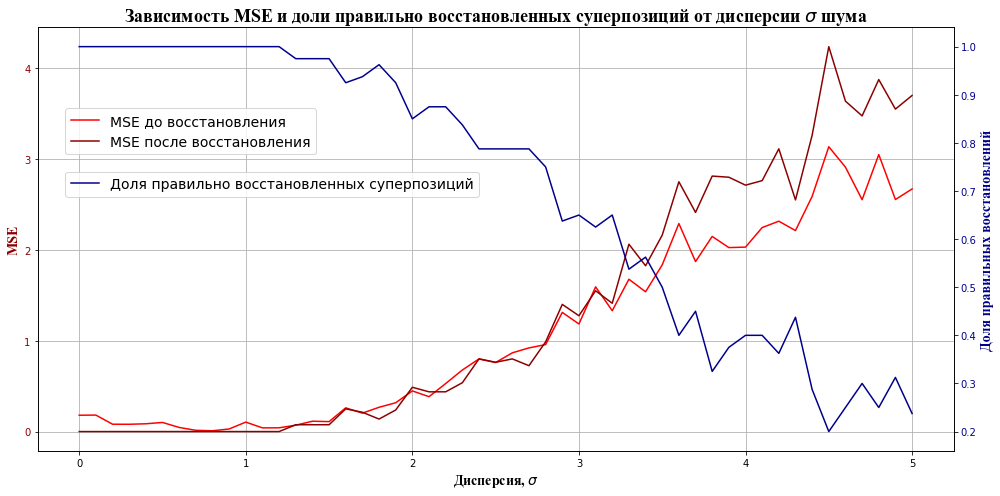

In [32]:
plt.rc('text', usetex=False)
# plt.rc('font', family='times')

csfont = {'fontname':'Times New Roman'}

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.grid(True)

color = 'darkred'
ax1.set_xlabel(u'Дисперсия, $\sigma$', fontsize=14, fontname='Times New Roman')
ax1.set_ylabel(u'MSE', color=color, fontsize=14, fontname='Times New Roman')
ax1.plot(sigmas, mses_before_restoration, color='red', label='MSE до восстановления')
ax1.plot(sigmas, mses_after_restoration, color='darkred', label='MSE после восстановления')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'darkblue'
ax2.set_ylabel(u'Доля правильных восстановлений', color=color, fontsize=14, fontname='Times New Roman')  # we already handled the x-label with ax1
ax2.plot(sigmas, recovered, color=color, label='Доля правильно восстановленных суперпозиций')
ax2.tick_params(axis='y', labelcolor=color)


ax1.set_title(u'Зависимость MSE и доли правильно восстановленных суперпозиций от дисперсии $\sigma$ шума',
              fontsize=18, fontname='Times New Roman')

ax1.legend(fontsize=14, loc=(0.03, 0.7), ncol=1)
ax2.legend(fontsize=14, loc=(0.03, 0.6), ncol=1)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('MSE_TPR_20_func_sincos.eps', format='eps', pad_inches=0.5)

plt.show()

### Пункт 2 (различные суперпозиции в test и train)

In [15]:
random.seed(a=472443)

MF_list = []

for i in range(0, 41):
    MF = MatrixFunc(f_list, var_number=1, sigma=0)
    MF = MakeRandomFunc(MF, 1)

    f, g = MF.MakeFunctionFromMatrix(print_func=True)
    
    flag = False
    for MF_old in MF_list:
        if (MF_old.adj_matrix == MF.adj_matrix).all():
            flag = True
            break
        
    # print(g)
    if not flag:
        MF_list.append(MF)

len(MF_list)

40

In [ ]:
def mse(ground_truth, predictions):
    # print((np.linalg.norm(ground_truth - predictions, axis=1) ** 2).shape, type(predictions))
    diff = (np.linalg.norm(ground_truth - predictions, axis=1) ** 2).sum() / len(predictions)
    return diff


def do_exp_sigma_dependancy_dataset(MF_list, X=np.linspace(0.0, 5.0, 251),
                                    sigma=0.0, tries=10):
    X = X.reshape(len(X), 1)
    # sigmas = np.linspace(0.0, 3.0, 4)
    # X = np.linspace(0.0, 5.0, 251)
    data_X = np.zeros((len(MF_list) * tries, len(X)))
    data_Y = np.zeros((len(MF_list) * tries, len(np.ravel(MF_list[0].adj_matrix))))

    for i, MF in enumerate(MF_list):
        MF.sigma = sigma
        for j in range(0, tries):
            data_X[i * tries + j] = MF(X)
            data_Y[i * tries + j] = np.ravel(MF_list[i].adj_matrix)

    return data_X, data_Y


def do_exp(MF_list, f_list, sigmas):
    
    mses_before_restoration = []
    mses_after_restoration = []
    recovered = []
    
    MF_list_train, MF_list_test = train_test_split(MF_list, test_size=0.4, random_state=42)
    
    for sigma in tqdm.tqdm_notebook(sigmas):
        
        # train_test_split(data_X, data_Y, data_Y_non_const, test_size=0.4, random_state=42)
        
        X_train, Y_train = do_exp_sigma_dependancy_dataset(MF_list_train, sigma=sigma)
        X_test, Y_test = do_exp_sigma_dependancy_dataset(MF_list_test, sigma=sigma)
        
        eps = 1e-05
        non_constant = Y_train.std(axis=0) > eps

        Y_train_non_const = Y_train[:, non_constant]
        Y_test_non_const = Y_test[:, non_constant]
        # print(data_Y_non_const.shape)
        # X_train, X_test, Y_train, Y_test, Y_train_non_const, Y_test_non_const = 
            
#         X_train, X_test, Y_train, Y_test, Y_train_non_const, Y_test_non_const = \
#             train_test_split(data_X, data_Y, data_Y_non_const, test_size=0.4, random_state=42)

        # print(Y_train_non_const.shape, Y_test_non_const.shape)

        params = {'estimator__C': np.logspace(-2, 2, 13)}

        clf = MultiOutputClassifier(LogisticRegression(penalty='l2'), n_jobs=1)



        grid_searcher = GridSearchCV(
                clf,
                params,
                n_jobs=4,
                scoring=make_scorer(mse, greater_is_better=False),
                cv=5,
                verbose=0,
                return_train_score='True'
        )

        grid_searcher = grid_searcher.fit(X_train, Y_train_non_const)

        # print(grid_searcher.best_params_['estimator__C'])
        
        clf = MultiOutputClassifier(\
            LogisticRegression(C=grid_searcher.best_params_['estimator__C'], penalty='l2'), n_jobs=4)
        clf.fit(X_train, Y_train_non_const)
        #clf.predict(X_test)[0]
        Y_test_pred = Y_test.copy()
        Y_test_pred[:, non_constant] = np.array([x[:, 1] for x in clf.predict_proba(X_test)]).T

        mses_before_restoration.append(mse(Y_test, Y_test_pred))

        new_MF_list = []
        for i in range(Y_test_pred.shape[0]):
            prob_matrix = Y_test_pred[i].reshape(MF_list[0].adj_matrix.shape)
            MF = MatrixFuncFromProbMatrix(f_list, prob_matrix, method='greedy_dfs')
            Y_test_pred[i] = np.ravel(MF.adj_matrix)

        mses_after_restoration.append(mse(Y_test, Y_test_pred))

        Y_test_pred = Y_test_pred.astype(int)

        TR_counter = 0
        for i in range(Y_test_pred.shape[0]):
            if (Y_test_pred[i] == Y_test[i]).all():
                TR_counter += 1

        recovered.append(TR_counter / Y_test_pred.shape[0])
    
    return mses_before_restoration, mses_after_restoration, recovered

In [16]:
MainSeedStorage = SeedStorage(42)

sigmas = np.linspace(0.0, 5.0, 51)

mses_before_restoration, mses_after_restoration, recovered = do_exp(MF_list, f_list, sigmas)

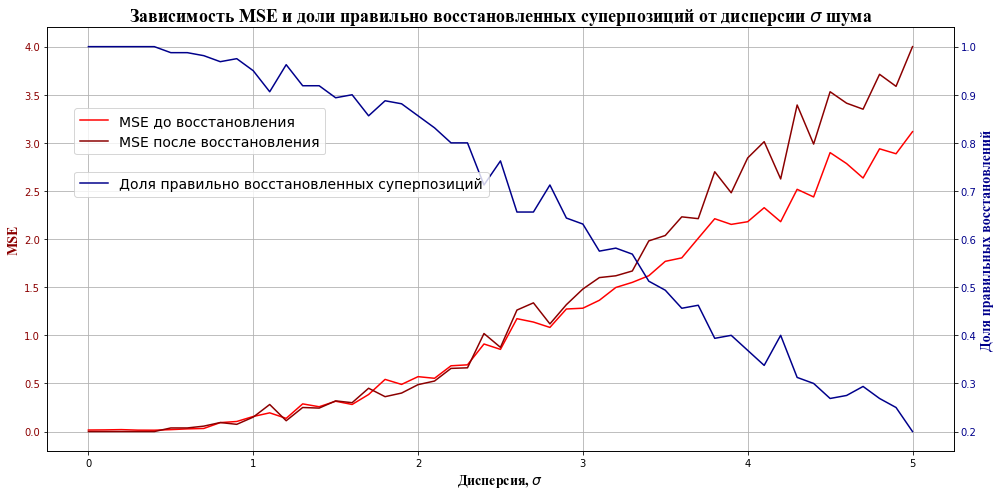

In [19]:
plt.rc('text', usetex=False)
# plt.rc('font', family='times')

csfont = {'fontname':'Times New Roman'}

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.grid(True)

color = 'darkred'
ax1.set_xlabel(u'Дисперсия, $\sigma$', fontsize=14, fontname='Times New Roman')
ax1.set_ylabel(u'MSE', color=color, fontsize=14, fontname='Times New Roman')
ax1.plot(sigmas, mses_before_restoration, color='red', label='MSE до восстановления')
ax1.plot(sigmas, mses_after_restoration, color='darkred', label='MSE после восстановления')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'darkblue'
ax2.set_ylabel(u'Доля правильных восстановлений', color=color, fontsize=14, fontname='Times New Roman')  # we already handled the x-label with ax1
ax2.plot(sigmas, recovered, color=color, label='Доля правильно восстановленных суперпозиций')
ax2.tick_params(axis='y', labelcolor=color)


ax1.set_title(u'Зависимость MSE и доли правильно восстановленных суперпозиций от дисперсии $\sigma$ шума',
              fontsize=18, fontname='Times New Roman')

ax1.legend(fontsize=14, loc=(0.03, 0.7), ncol=1)
ax2.legend(fontsize=14, loc=(0.03, 0.6), ncol=1)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('MSE_TPR_40_func_sincos_different_superpositions.eps', format='eps', pad_inches=0.5)

plt.show()

#### 3) То же что и в 2 но с большей сложностью.

In [42]:
random.seed(a=472443)

MF_list = []

for i in range(0, 500):
    MF = MatrixFunc(f_list, var_number=1, sigma=0)
    MF = MakeRandomFunc(MF, 2)

    f, g = MF.MakeFunctionFromMatrix(print_func=True)
    
    flag = False
    for MF_old in MF_list:
        if (MF_old.adj_matrix == MF.adj_matrix).all():
            flag = True
            break
        
    # print(g)
    if not flag:
        MF_list.append(MF)

len(MF_list)

498

In [43]:
def mse(ground_truth, predictions):
    # print((np.linalg.norm(ground_truth - predictions, axis=1) ** 2).shape, type(predictions))
    diff = (np.linalg.norm(ground_truth - predictions, axis=1) ** 2).sum() / len(predictions)
    return diff


def do_exp_sigma_dependancy_dataset(MF_list, X=np.linspace(0.0, 5.0, 251),
                                    sigma=0.0, tries=10):
    X = X.reshape(len(X), 1)
    # sigmas = np.linspace(0.0, 3.0, 4)
    # X = np.linspace(0.0, 5.0, 251)
    data_X = np.zeros((len(MF_list) * tries, len(X)))
    data_Y = np.zeros((len(MF_list) * tries, len(np.ravel(MF_list[0].adj_matrix))))

    for i, MF in enumerate(MF_list):
        MF.sigma = sigma
        for j in range(0, tries):
            data_X[i * tries + j] = MF(X)
            data_Y[i * tries + j] = np.ravel(MF_list[i].adj_matrix)

    return data_X, data_Y


def do_exp(MF_list, f_list, sigmas):
    
    mses_before_restoration = []
    mses_after_restoration = []
    recovered = []
    
    MF_list_train, MF_list_test = train_test_split(MF_list, test_size=0.2, random_state=42)
    
    for sigma in tqdm.tqdm_notebook(sigmas):
        
        # train_test_split(data_X, data_Y, data_Y_non_const, test_size=0.4, random_state=42)
        
        X_train, Y_train = do_exp_sigma_dependancy_dataset(MF_list_train, sigma=sigma)
        X_test, Y_test = do_exp_sigma_dependancy_dataset(MF_list_test, sigma=sigma)
        
        eps = 1e-05
        non_constant = Y_train.std(axis=0) > eps
        
        Y_train_non_const = Y_train[:, non_constant]
        Y_test_non_const = Y_test[:, non_constant]
        print(Y_train_non_const.sum(axis=0))

        params = {'estimator__C': np.logspace(-2, 2, 13)}

        clf = MultiOutputClassifier(LogisticRegression(penalty='l2'), n_jobs=1)



        grid_searcher = GridSearchCV(
                clf,
                params,
                n_jobs=4,
                scoring=make_scorer(mse, greater_is_better=False),
                cv=5,
                verbose=0,
                return_train_score='True'
        )

        grid_searcher = grid_searcher.fit(X_train, Y_train_non_const)

        # print(grid_searcher.best_params_['estimator__C'])
        
        clf = MultiOutputClassifier(\
            LogisticRegression(C=grid_searcher.best_params_['estimator__C'], penalty='l2'), n_jobs=4)
        clf.fit(X_train, Y_train_non_const)
        #clf.predict(X_test)[0]
        Y_test_pred = Y_test.copy()
        Y_test_pred[:, non_constant] = np.array([x[:, 1] for x in clf.predict_proba(X_test)]).T

        mses_before_restoration.append(mse(Y_test, Y_test_pred))

        new_MF_list = []
        for i in range(Y_test_pred.shape[0]):
            prob_matrix = Y_test_pred[i].reshape(MF_list[0].adj_matrix.shape)
            MF = MatrixFuncFromProbMatrix(f_list, prob_matrix, method='greedy_dfs')
            Y_test_pred[i] = np.ravel(MF.adj_matrix)

        mses_after_restoration.append(mse(Y_test, Y_test_pred))

        Y_test_pred = Y_test_pred.astype(int)

        TR_counter = 0
        for i in range(Y_test_pred.shape[0]):
            if (Y_test_pred[i] == Y_test[i]).all():
                TR_counter += 1

        recovered.append(TR_counter / Y_test_pred.shape[0])
    
    return mses_before_restoration, mses_after_restoration, recovered

In [ ]:
MainSeedStorage = SeedStorage(42)

sigmas = np.linspace(0.0, 5.0, 51)

mses_before_restoration, mses_after_restoration, recovered = do_exp(MF_list, f_list, sigmas)

# А теперь восстановление матриц суперпозиций

Нам понадобится:
    - Функция их порождения для набора заданных арностей. Инит функция - есть всегда (выделенный корень)
    - 3-4 способа восстановления
    - Собственно генерация набора арностей, набора $N$ матриц корректных суперпозиций, зашумление
    - Восстановление (способами определенными выше), подсчет числа правильно восстановленных

##### Функция порождения и зашумления для набора арностей

In [156]:
def MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=-1):
    '''
    Creates a random matrix given vertices arities (root is added)
    
    Parameters
    -------------------------------------------------
    arities:
        list of integers - arities of corresponding functions
    
    var_number:
        number of variables (x,y,...)

    complexity_limit:
        Specifies the depth of a function complexity (max depth from root)
    '''
    func_num = 1 + len(arities)
    total_num = func_num + var_number
    
    arities = [1] + arities + [0] * var_number
    
    queue = [(0, 0)]

    adj_matrix = np.zeros((func_num, total_num))
    
    var_set = set(range(total_num)) - set(range(func_num))
    not_used = set(range(func_num)) - set([queue[0][0]])
            
    while not len(queue) == 0:
        func =  queue[0][0]
        cmplx = queue[0][1]
        func_arity = arities[func]

        chosen = []
        if (cmplx < complexity_limit or complexity_limit == -1):
            if len(not_used) >= func_arity:
                chosen = random.sample(not_used, func_arity)
            else:
                chosen = random.sample(not_used, len(not_used))

        # print(var_set)
        while len(chosen) < func_arity:
            chosen.append(random.sample(var_set, 1)[0])

        for chosen_elem in chosen:
            if chosen_elem < func_num + 1:
                not_used = not_used - set([chosen_elem])
                queue.append((chosen_elem, cmplx + 1))
            adj_matrix[queue[0][0], chosen_elem] = 1
        queue[:] = queue[1:]
    return adj_matrix

def AddNoiseToMatrix(matrix, noise_level=0,
                     noise_variant='uniform', calibration_variant='sigmoid'):
    '''
    Adds noise to matrix
    
    Parameters
    -------------------------------------------------
    matrix:
        0-1 matrix with dtype=int 
    
    noise_level:
        used as parameter for chosen variant

    noise_variant:
        Specifies the variant of noise
        noise_variant == 'uniform':
            noisy_matrix = matrix + np.random.uniform(low=-noise_level, high=noise_level)
        noise_variant == 'normal':
            noisy_matrix = matrix + np.random.normal(scale=noise_level)
    calibration_variant:
        Specifies the variant of caluibration
        calibration_variant == 'sigmoid':
            return(1 / (1 + np.exp(-noisy_matrix)))
        calibration_variant == 'linear':
            noisy_matrix -= noisy_matrix.min()
            noisy_matrix = noisy_matrix / noisy_matrix.max()
            return(noisy_matrix)
        
    '''
    noisy_matrix = matrix.copy()
    if noise_variant == 'uniform':
        noisy_matrix += np.random.uniform(low=-noise_level, high=noise_level,
                                         size=noisy_matrix.shape)
    elif noise_variant == 'normal':
        noisy_matrix += np.random.normal(scale=noise_level,
                                         size=noisy_matrix.shape)
    else:
        raise ValueError('No such noise variant: {}'.format(noise_variant))

    if calibration_variant == 'sigmoid':
        noisy_matrix = 1 / (1 + np.exp(-noisy_matrix))
    elif calibration_variant == 'linear':
        noisy_matrix -= noisy_matrix.min()
        noisy_matrix = noisy_matrix / noisy_matrix.max()
    else:
        raise ValueError('No such calibration variant: {}'.format(calibration_variant))
    
    return noisy_matrix

Проверяем ее работу, заодно приведем функцию генерации случайного набора арностей

In [385]:
np.random.seed(421)
random.seed(a=472443)

def GenerateAritiesList(size, max_arity=2, p=0.2):
    return (np.random.binomial(max_arity - 1, p, size=size) + 1).tolist()

arities = GenerateAritiesList(3)
var_number = 1
print(arities)

new_matrix = MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=-1)

print(new_matrix)

noisy_matrix = AddNoiseToMatrix(new_matrix, noise_level=0.0,
                                noise_variant='uniform', calibration_variant='linear')

print(noisy_matrix)

[1, 2, 1]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]


##### Методы восстановления

In [662]:
def RestoreMatrix(arities, var_number, prob_matrix,
                  method='greedy_dfs', eps=1e-03, max_cmplx=-1, prize_coef=1.0):
    '''
    Creates a MatrixFunc object given func_list and
    probabilities matrix prob_matrix using specified method
    
    
    Parameters
    -------------------------------------------------
    arities:
        List of integers - arities of corresponding functions

    prob_matrix:
        Probabilities matrix to restore a matrix defining a
        superposition

    method:
        A restoration method

    eps:
        used to drop zero-like elements
    '''
    prob_matrix = prob_matrix.copy()
    adj_matrix = np.zeros(prob_matrix.shape, dtype=int)

    if method == 'greedy_bfs':

        func_num = 1 + len(arities)
        total_num = func_num + var_number

        arities = [1] + arities + [0] * var_number

        queue = [(0, 0)]

        var_set = set(range(total_num)) - set(range(func_num))
        used = set([queue[0][0]])

        while not len(queue) == 0:
            func =  queue[0][0]
            cmplx = queue[0][1]
            func_arity = arities[func]
            
            matrix_row = prob_matrix[func].copy()
            matrix_row[list(used)] = 0
            
            if (cmplx >= max_cmplx and not max_cmplx == -1):
                matrix_row[list(range(func_num))] = 0

            best_variable_number = matrix_row[func_num:].argmax() + func_num
            
            chosen = []
            new_level_func = None
            
            for i in range(0, func_arity):
                new_argmax = np.argmax(matrix_row)
                if (matrix_row[new_argmax] < eps):
                    new_argmax = best_variable_number
                
                matrix_row[new_argmax] = 0
                adj_matrix[func, new_argmax] = 1
                chosen.append(new_argmax)

            for chosen_elem in chosen:
                if chosen_elem < func_num:
                    used.add(chosen_elem)
                    queue.append((chosen_elem, cmplx + 1))
                adj_matrix[queue[0][0], chosen_elem] = 1
            queue[:] = queue[1:]
        return adj_matrix
    elif method == 'greedy_dfs':
        arities = [1] + arities
        def GreedyRestoreDFS(arities, var_number, prob_matrix, new_matrix,
                             max_cmplx=-1, cmplx=0, level=0, used=set([0]), eps=1e-03):
            
            func_num = len(arities)
            total_num = func_num + var_number
            
            func = level
            func_arity = arities[func]
            
            # level_func = func_list[level]
            matrix_row = prob_matrix[level].copy()
            #print(matrix_row)
            matrix_row[list(used)] = 0
            
            if (cmplx >= max_cmplx and not max_cmplx == -1):
                matrix_row[list(range(func_num))] = 0
            
            best_variable_number = matrix_row[func_num:].argmax() + func_num
            #print(best_variable_number)
            
            chosen = []
            new_level_func = None
            
            for i in range(0, func_arity):
                new_argmax = np.argmax(matrix_row)
                if (matrix_row[new_argmax] < eps):
                    new_argmax = best_variable_number
                
                matrix_row[new_argmax] = 0
                new_matrix[func, new_argmax] = 1
                
                if new_argmax < func_num:
                    used.add(new_argmax)
                
                chosen.append(new_argmax)

            for chosen_func in chosen:
                if chosen_func < func_num:
                    # print('Before, Level = {}, used = {}'.format(level, used))
                    GreedyRestoreDFS(arities, var_number, prob_matrix, new_matrix,
                                     max_cmplx, cmplx + 1, chosen_func, used, eps)
                    # print('After,  Level = {}, used = {}'.format(level, used))

            return

        GreedyRestoreDFS(arities, var_number, prob_matrix, adj_matrix,
                         max_cmplx=max_cmplx, cmplx=0, level=0, used=set([0]), eps=eps)
        
        return adj_matrix

    elif method == 'prim':
        arities = [1] + arities
        func_num = len(arities)

        # func_prob_matr = prob_matrix[:, :func_num]
        
        last_added = 0
        used = set([0])
        
        edges = []
        weights = []

        while not last_added is None:
            # print(last_added)
            # print(edges, weights)
            
            if last_added < func_num:
                func = last_added

                matrix_row = prob_matrix[func].copy()
                matrix_row[list(used)] = 0

                for to in range(len(matrix_row)):
                    if matrix_row[to] > eps:
                        edges.append((func, to))
                        weights.append(matrix_row[to])
            
            # print(edges, weights)
            # print(arities)
            if len(edges) == 0:
                last_added = None
            else:
                max_edge_num = np.array(weights).argmax()
                max_edge = edges[max_edge_num]

                from_vert = max_edge[0]
                to_vert = max_edge[1]
                
                adj_matrix[from_vert, to_vert] = 1
                
                if to_vert < func_num:
                    used.add(to_vert)
                
                last_added = to_vert
                
                arities[from_vert] -= 1
                
                # Cleaning
                to_drop = set([max_edge_num])
                for i, edge in enumerate(edges):
                    if edge[1] in used:
                        to_drop.add(i)

                if arities[from_vert] == 0:
                    for i, edge in enumerate(edges):
                        if edge[0] == from_vert:
                            to_drop.add(i)
                            
                edges = [e for i, e in enumerate(edges) if i not in to_drop]
                weights = [w for i, w in enumerate(weights) if i not in to_drop]

        return adj_matrix

    elif method == 'kmst-pure':
        func_num = 1 + len(arities)
        total_num = func_num + var_number
        
        new_prob_matr = np.zeros((func_num, func_num + func_num))
        
        for i in range(0, func_num):
            prob_matrix[i, 0] = 0
            
        new_prob_matr[:, :func_num] = prob_matrix[:, :func_num]
        
        for i in range(0, func_num):
            new_prob_matr[i, i] = 0
            new_prob_matr[i, i+func_num] = prob_matrix[i, func_num]
        
        edges = []
        costs = []
        for i in range(0, func_num):
            for j in range(0, func_num + func_num):
                if new_prob_matr[i, j] > eps:
                    edges.append([i, j])
                    costs.append(1 - new_prob_matr[i, j] + eps)
                    
        edges = np.array(edges)
        prizes = np.ones(func_num * 2) * prize_coef
        root = 0
        num_clusters = 1
        pruning = 'none'
        verbosity_level = 0
        
        vertices, chosen_edges = pcst_fast.pcst_fast(\
            edges, prizes, costs, root, num_clusters, pruning, verbosity_level)

        prob_matrix[:, :] = 0
        for edge_number in chosen_edges:
            edge = edges[edge_number]
            if edge[1] < func_num:
                prob_matrix[edge[0], edge[1]] = 1
            else:
                prob_matrix[edge[0], func_num] = 1
            
        return prob_matrix

    elif method == 'kmst-bfs':
        func_num = 1 + len(arities)
        total_num = func_num + var_number
        
        for i in range(0, func_num):
            prob_matrix[i, 0] = 0
            
        func_prob_matr = prob_matrix[:, :func_num]
        
        edges = []
        costs = []
        for i in range(0, func_num):
            for j in range(0, func_num):
                if func_prob_matr[i, j] > eps:
                    edges.append([i, j])
                    costs.append(1 - func_prob_matr[i, j] + eps)
                    
        edges = np.array(edges)
        prizes = np.ones(func_num) * prize_coef
        root = 0
        num_clusters = 1
        pruning = 'none'
        verbosity_level = 0
        
        vertices, chosen_edges = pcst_fast.pcst_fast(\
            edges, prizes, costs, root, num_clusters, pruning, verbosity_level)

        prob_matrix[:, :func_num] = 0
        for edge_number in chosen_edges:
            edge = edges[edge_number]
            prob_matrix[edge[0], edge[1]] = 1
            
        return RestoreMatrix(arities, var_number, prob_matrix, 'greedy_bfs', eps, max_cmplx)

    elif method == 'kmst-prim':
        func_num = 1 + len(arities)
        total_num = func_num + var_number
        
        new_prob_matr = np.zeros((func_num, func_num + func_num))
        
        for i in range(0, func_num):
            prob_matrix[i, 0] = 0
            
        new_prob_matr[:, :func_num] = prob_matrix[:, :func_num]
        
        for i in range(0, func_num):
            new_prob_matr[i, i] = 0
            new_prob_matr[i, i+func_num] = prob_matrix[i, func_num]
        
        edges = []
        costs = []
        for i in range(0, func_num):
            for j in range(0, func_num + func_num):
                if new_prob_matr[i, j] > eps:
                    edges.append([i, j])
                    costs.append(1 - new_prob_matr[i, j] + eps)
                    
        edges = np.array(edges)
        prizes = np.ones(func_num * 2) * prize_coef
        root = 0
        num_clusters = 1
        pruning = 'none'
        verbosity_level = 0
        
        vertices, chosen_edges = pcst_fast.pcst_fast(\
            edges, prizes, costs, root, num_clusters, pruning, verbosity_level)

        #prob_matrix[:, :] = 0
        for edge_number in chosen_edges:
            edge = edges[edge_number]
            if edge[1] < func_num:
                prob_matrix[edge[0], edge[1]] += 0.5
                prob_matrix[edge[0], edge[1]] /= 1.5
            else:
                prob_matrix[edge[0], func_num] += 0.5
                prob_matrix[edge[0], func_num] /= 1.5

        return RestoreMatrix(arities, var_number, prob_matrix, 'prim', eps, max_cmplx)

In [667]:
RestoreMatrix(arities, var_number, noisy_matrix,
              method='prim', eps=0.0001, max_cmplx=2, prize_coef=1)

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1]])

##### Генерируем данные. 
    - Берем 200 наборов арностей (5 - 50 длина)
    - Для каждого генерируем 100 матриц
    - Полученный набор сохраняем
    - Перебираем шумы
    - Зашумляем (по 10 раз), восстанавливаем
    - Параметры: Способ зашумления, способ калибровки, число переменных, наличие больших арностей, максимальная сложность

In [736]:
def GenerateAritiesList(size, max_arity=2, p=0.2):
    return (np.random.binomial(max_arity - 1, p, size=size) + 1).tolist()


def do_exp(arities_number=200, arity_sizes=(5, 50), restor_algs=['greedy_dfs', 'greedy_bfs', 'prim', 'kmst'],
           matrices_per_arity_number=100, noisy_matrices_number=100, 
           noises=np.linspace(0.0, 1.0, 51),
           noise_variant='normal', calibration_variant='sigmoid',
           var_number=1, max_arity=2, max_cmplx=-1, p=0.2, prize_coef=0.95, leave_multiple=False):
    
#     print(arities_number, arity_sizes, restor_algs, matrices_per_arity_number, noisy_matrices_number,
#          noises, noise_variant, calibration_variant, var_number, max_arity, max_cmplx, p, leave_multiple, prize_coef)
    
    arities_list = []
    for i in range(0, arities_number):
        arities_list.append(GenerateAritiesList(random.randint(arity_sizes[0], arity_sizes[1]), max_arity, p))
    
    matrices_list = []

    for arities in arities_list:
        for j in range(0, matrices_per_arity_number):
            matrices_list.append((arities,
                                 MakeRandomCorrectAdjMatrix(arities, var_number, complexity_limit=max_cmplx)))
        
    recovered = []
    
    total = arities_number * matrices_per_arity_number * noisy_matrices_number
    
    for noise_level in tqdm.tqdm_notebook(noises, leave=leave_multiple):
        recovered_per_alg = [0] * len(restor_algs)
        for arities, matrix in matrices_list:
            for j in range(noisy_matrices_number):
                noisy_matrix = AddNoiseToMatrix(matrix, noise_level, noise_variant, calibration_variant)
                for i, alg in enumerate(restor_algs):
                    # print (noisy_matrix)
                    rest_matrix = RestoreMatrix(arities, var_number, noisy_matrix,
                                                alg, 0.0001, max_cmplx, prize_coef)
                    if (np.round(matrix) == np.round(rest_matrix)).all():
                        recovered_per_alg[i] += 1

        recovered.append(recovered_per_alg)
    return np.array(recovered).T / total

def make_plot(algs, recovered):
    plt.rc('text', usetex=False)

    csfont = {'fontname':'Times'}

    plt.figure(figsize=(4, 7))
    plt.grid(True)

    X = np.linspace(0.0, 1.0, 51)

    plt.plot(X, recovered[0], label='dfs', color='red')
    plt.plot(X, recovered[1], label='bfs', color='blue')
    plt.plot(X, recovered[2], label='prim', color='darkorange')
    plt.plot(X, recovered[-1], label='kmst', color='green')

    plt.ylabel('Доля правильных восстановлений', fontsize=14, **csfont)
    plt.xlabel('Шум', fontsize=14, **csfont)

    plt.title('Процент корректных восстановлений от силы шума', fontsize=18, **csfont)

    plt.legend(loc='upper right', fontsize=14)
    
def do_exp_multiple(repeats=10, *args, **kwargs):
    kwargs.update({'leave_multiple': False})

    recovered_total = None

    for i in tqdm.tqdm_notebook(range(repeats)):
        recovered = do_exp(*args, **kwargs)
        if recovered_total is None:
            recovered_total = np.zeros((repeats, recovered.shape[0], recovered.shape[1]))
            recovered_total[0] = recovered
        else:
            recovered_total[i] = recovered
    
    return recovered_total

def make_plot_multiple(algs, recovered, repeats,
                       alpha_rep=0.2, alpha_area=0.1, X=np.linspace(0.0, 1.0, 51),
                       saveas=None):
    plt.rc('text', usetex=False)

    csfont = {'fontname':'Times'}

    plt.figure(figsize=(4, 7))
    plt.grid(True)

    recovered_means = recovered.mean(axis=0)
    recovered_stds = recovered.std(axis=0)
    top = recovered_means + 2 * recovered_stds
    top[top > 1.0] = 1.0
    
    bot = recovered_means - 2 * recovered_stds
    bot[bot < 0.0] = 0.0
    
    colors = ['r', 'g', 'darkorange', 'b', 'cyan', 'purple']
    labels = ['DFS', 'BFS', 'Prim\'s', 'k-MST', 'k-MST-BFS', 'k-MST-Prim\'s']
    
    for i in range(0, len(algs)):
        for j in range(0, repeats):
            plt.plot(X, recovered[j, i], color=colors[i], alpha=alpha_rep)
        plt.plot(X, recovered_means[i], label=labels[i], color=colors[i])
        if algs[i] == 'prim' or algs[i] == 'kmst-prim':
            plt.fill_between(X, top[i], bot[i], color=colors[i], alpha=alpha_area)
        
    
    # plt.plot(X, recovered.min(axis=0)[-1], linestyle='--', label='k-MST, min', color='black')
    

    plt.ylabel('Доля правильных восстановлений', fontsize=14)
    plt.xlabel('Шум', fontsize=14)

    plt.title('', fontsize=18)

    plt.legend(loc='upper right', fontsize=14)
    
    if not saveas is None:
        plt.savefig(saveas, format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

# Эксперименты

### main graph

In [723]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim', 'kmst-pure', 'kmst-bfs', 'kmst-prim']

In [724]:
%%time

repeats = 1

recovered_total = []
for alg in algs:
    np.random.seed(421)
    random.seed(a=472443)
    recovered_total_per_alg = do_exp_multiple(repeats,
                                              1, (5, 50), [alg], 20, 5, np.linspace(0.0, 1.0, 51),
                                              'uniform', 'linear', 1, 5, -1, 0.1, 0.5)
    recovered_total.append(recovered_total_per_alg)

CPU times: user 1h 18min 56s, sys: 12.1 s, total: 1h 19min 8s
Wall time: 1h 19min 16s


In [725]:
recovered_total[0].shape

(100, 1, 51)

In [726]:
new_recovered_total_array = np.zeros((recovered_total[0].shape[0], 6, recovered_total[0].shape[2]))
for i, rec in enumerate(recovered_total):
    new_recovered_total_array[:, i:i+1, :] = rec.copy()

In [727]:
new_recovered_total_array.shape

(100, 6, 51)

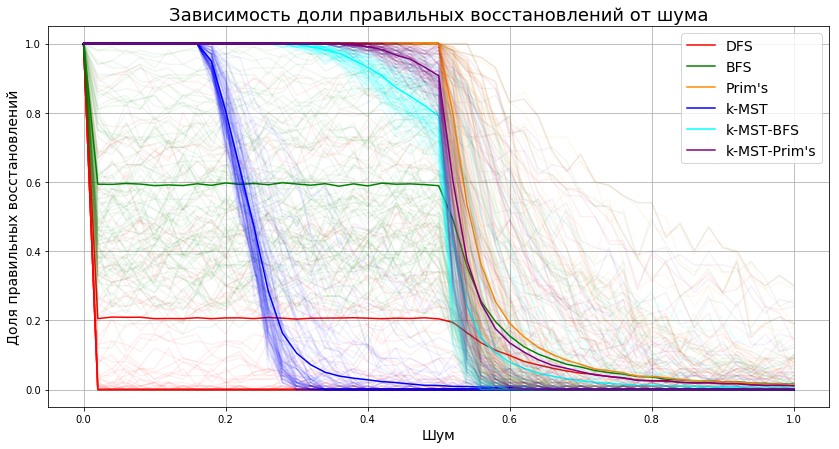

In [728]:
make_plot_multiple(algs, new_recovered_total_array, repeats, 0.06, 0.0, np.linspace(0.0, 1.0, 51))

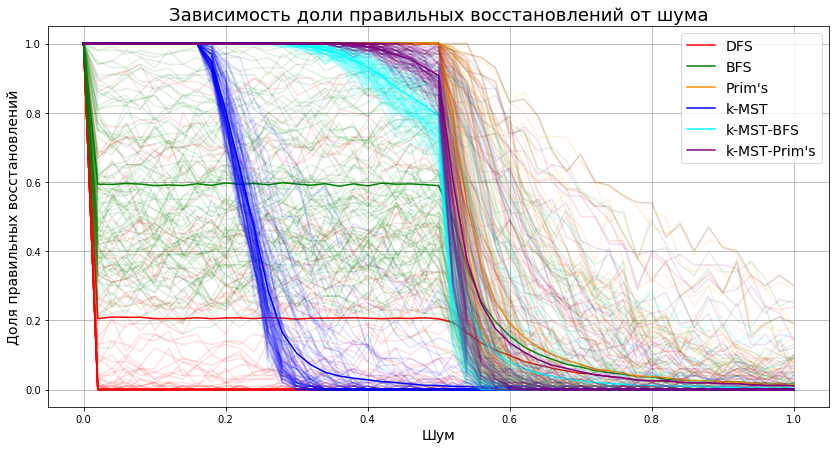

In [734]:
saveas='main_graph_100_1_20_5_alpha012_maxarity_5.pdf'

make_plot_multiple(algs, new_recovered_total_array, repeats, 0.12, 0.0, np.linspace(0.0, 1.0, 51), saveas)

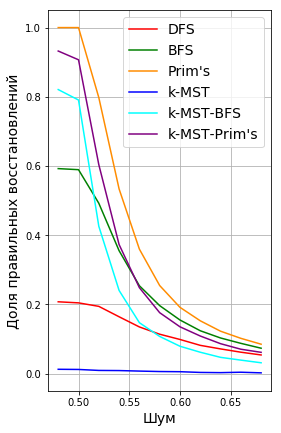

In [737]:
saveas='main_graph_100_1_20_5_alpha000_maxarity_5_local.pdf'

make_plot_multiple(algs, new_recovered_total_array[:,:,24:35], repeats, 0.0, 0.0, np.linspace(0.48, 0.68, 11), saveas)

In [738]:
(new_recovered_total_array[:,:,25:30].mean(axis=0)*100).round()/100

array([[0.2 , 0.19, 0.16, 0.13, 0.11],
       [0.59, 0.49, 0.36, 0.25, 0.2 ],
       [1.  , 0.8 , 0.53, 0.36, 0.25],
       [0.01, 0.01, 0.01, 0.01, 0.01],
       [0.79, 0.43, 0.24, 0.15, 0.11],
       [0.91, 0.6 , 0.37, 0.25, 0.18]])

# Время

In [ ]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim', 'kmst-pure', 'kmst-bfs', 'kmst-prim']

In [ ]:
%%time

print(algs[0])

np.random.seed(421)
random.seed(a=472443)

repeats = 100

do_exp_multiple(repeats, 1, (5, 50), list(algs[0]), 20, 5, np.linspace(0.0, 1.0, 51),
                'uniform', 'linear', 1, 2, -1, 0.2, 0.5)

# Temp

In [12]:
import matplotlib.font_manager
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print(names)
plt.rcParams

['Arial Black', 'Trebuchet MS', 'IBM Plex Serif', 'Latin Modern Roman', 'Noto Serif', 'CMU Bright', 'drmittc12', 'Antykwa Torunska Condensed', 'drmitsc12', 'Caladea', 'Overlock', 'drmscbx8', 'TeX Gyre Pagella', 'Roboto Slab', 'drmui9', 'drml17', 'Source Sans Pro', 'IBM Plex Serif', 'Overlock', 'FreeMono', 'Noto Sans', 'drmuibx14', 'Berenis ADF Pro SC', 'Antykwa Poltawskiego', 'CMU Serif', 'drmuibx24', 'Kurier Cond Medium', 'drmdozit9', 'Mint Spirit', 'IBM Plex Mono', 'drmscbx9', 'Cabin Condensed', 'drmdozsl24', 'Go Mono', 'drmtc9', 'Fira Mono', 'drmui8', 'drmdozb24', 'Source Sans Pro', 'drmuibx17', 'Latin Modern Mono Slanted', 'IBM Plex Mono', 'drmdozsl17', 'Fetamont', 'Gillius ADF No2 Cond', 'Montserrat', 'drmdozb14', 'drmdozitbx11', 'drmdozit8', 'Alegreya Sans', 'Libertinus Serif', 'PT Serif', 'Antykwa Torunska Condensed', 'Iwona Heavy', 'Antykwa Poltawskiego', 'Fetamont', 'CMU Serif', 'TeX Gyre Termes', 'Coelacanth', 'drmdozsl14', 'drminf17', 'drmtc8', 'MnSymbol', 'Amiri', 'Alegreya

In [744]:
the_biggest_recover_with_big_arities = new_recovered_total_array.copy()

In [717]:
the_biggest_recover = new_recovered_total_array.copy()

In [745]:
np.save('with_big_arities', the_biggest_recover_with_big_arities)
np.save('without_big_arities', the_biggest_recover)

In [ ]:
np.array()

In [ ]:
c[list(a)] = 0

In [ ]:
c

In [63]:
# fourier_feat_gen = feature_generators.FourierFG(threshold=20)

# X_fourier = timeseries.ExtractFeatures(data_X,
#     lambda ts: fourier_feat_gen(ts)
# )
# X_fourier.shape
# print(X_fourier)

In [ ]:
b

In [ ]:
[''] * 3

In [4]:
a = [0]

In [120]:
rg = np.random.RandomState(1).normal

In [121]:
rg(size=100)

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
       -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
       -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
       -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
       -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
       -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
       -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
        0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
        0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
       -0.75439794,  1.25286816,  0.51292982, -0.29809284,  0.48851815,
       -0.07557171,  1.13162939,  1.51981682,  2.18557541, -1.39

In [98]:
a 

array([0. , 0. , 0. , 0.1])

In [100]:
a[[1, 2, 3]]

array([0. , 0. , 0.1])

In [287]:
edges = [1, 2, 3, 4, 5, 6]
to_drop = [0, 4, 2]
edges = [e for i, e in enumerate(edges) if i not in to_drop]

In [288]:
edges

[2, 4, 6]

In [376]:
algs = ['greedy_dfs', 'greedy_bfs', 'prim', 'kmst']

#### 1) normal, linear, 1, 2, -1

In [377]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 5, 5, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 1, 2, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


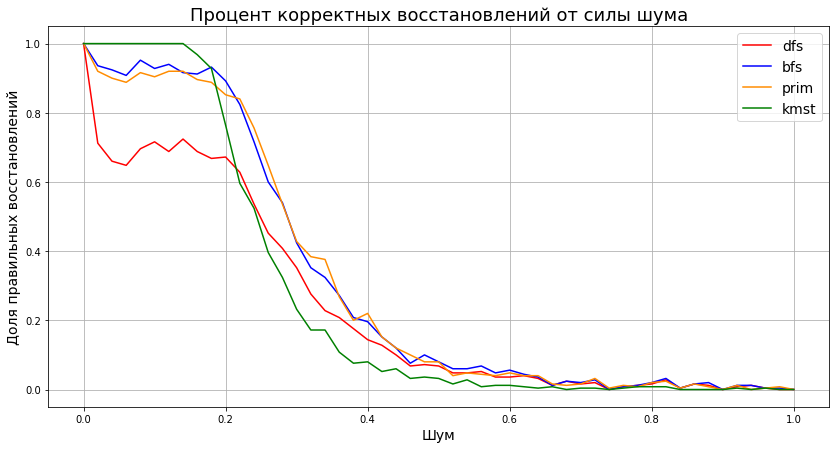

In [378]:
make_plot(algs, recovered)

#### 2) 'normal', 'linear', 2, 2, -1

In [242]:
np.random.seed(421)
random.seed(a=472443)



recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 2, 2, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


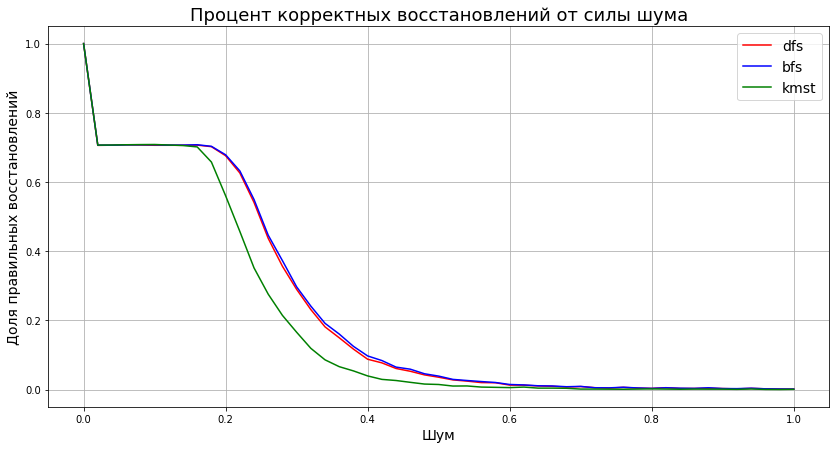

In [244]:
make_plot(algs, recovered)

#### 3) 'normal', 'linear', 1, 5, -1

In [245]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 1, 5, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


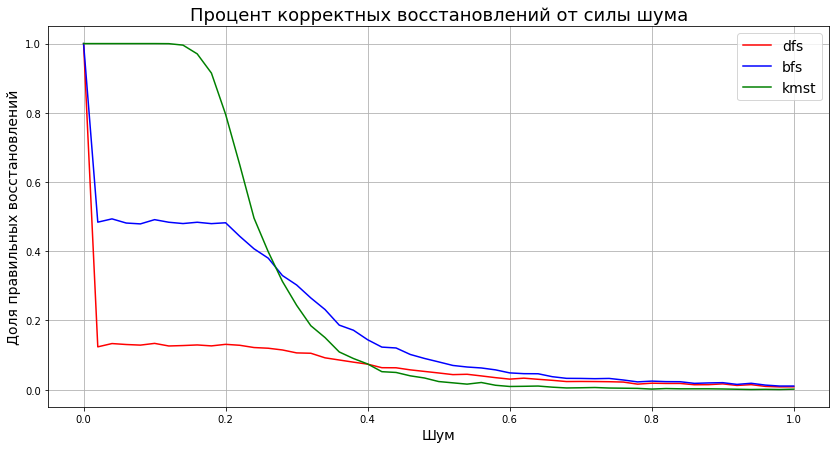

In [246]:
make_plot(algs, recovered)

#### 4) 'normal', 'linear', 1, 3, 2

In [254]:
np.random.seed(421)
random.seed(a=472443)

recovered = do_exp(10, (5, 50), algs, 20, 20, np.linspace(0.0, 1.0, 51),
                   'normal', 'linear', 2, 3, -1, 0.2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


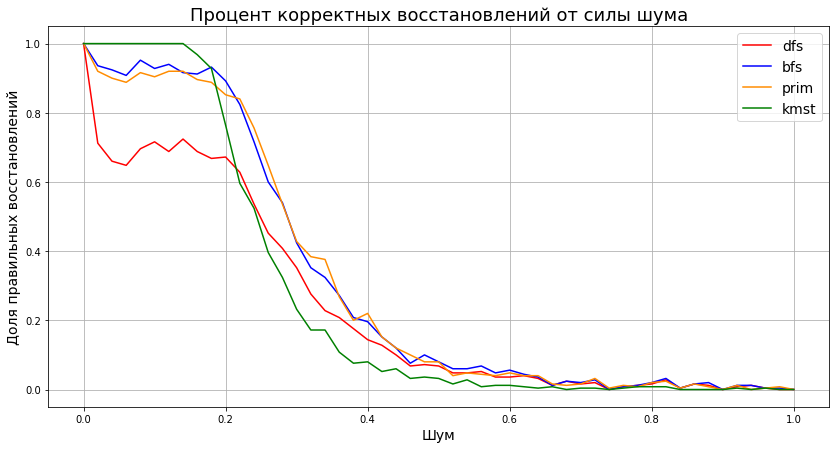

In [383]:
make_plot(algs, recovered)